In [38]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [47]:
class MemoryMappedGlucoseDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Path to the root folder containing patient folders.
        """
        self.root_dir = root_dir
        self.patient_folders = sorted([
            f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))
        ])
    
    def __len__(self):
        return len(self.patient_folders)

    def __getitem__(self, idx):
        """
        Loads a patient's glucose.csv file using memory mapping.
        Returns:
            X: Torch tensor of glucose readings.
            y: Corresponding target labels (e.g., next glucose value or classification label).
        """
        patient_folder = self.patient_folders[idx]
        patient_glucose_path = os.path.join(self.root_dir, patient_folder, 'glucose.csv')

        if not os.path.exists(patient_glucose_path):
            raise FileNotFoundError(f"Missing file: {patient_glucose_path}")

        # Load glucose data with memory mapping
        glucose_df = pd.read_csv(patient_glucose_path, memory_map=True)
        
        # Convert to NumPy (assuming glucose values are in a column named 'glucose')
        X = glucose_df['glucose'].iloc[0:100].values  # All but last column
        y = glucose_df['glucose'].iloc[101:102].values   # Last column (e.g., target glucose levels)

        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        return X_tensor, y_tensor

In [48]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class GlucoseTimeSeriesDataset(Dataset):
    def __init__(self, root_dir, seq_length=99, pred_length=10):
        self.root_dir = root_dir
        self.patient_folders = sorted([
            f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))
        ])
        self.seq_length = seq_length
        self.pred_length = pred_length

    def __len__(self):
        return len(self.patient_folders)

    def __getitem__(self, idx):
        patient_folder = self.patient_folders[idx]
        patient_glucose_path = os.path.join(self.root_dir, patient_folder, 'glucose.csv')

        if not os.path.exists(patient_glucose_path):
            raise FileNotFoundError(f"Missing file: {patient_glucose_path}")

        # Load glucose data using memory mapping
        glucose_df = pd.read_csv(patient_glucose_path, memory_map=True)

        # Extract glucose values
        glucose_values = glucose_df.iloc[:, -1].values

        # Ensure enough data
        if len(glucose_values) < self.seq_length + self.pred_length:
            pad_size = (self.seq_length + self.pred_length) - len(glucose_values)
            glucose_values = list(glucose_values) + [0] * pad_size  # Pad with zeros

        # Sliding window for past 99 steps
        X = torch.tensor(glucose_values[:self.seq_length], dtype=torch.float32).unsqueeze(-1)  # Shape [99, 1]
        # Future values one step at a time
        y = torch.tensor(glucose_values[self.seq_length:self.seq_length + self.pred_length], dtype=torch.float32)

        return X, y


In [49]:
from torch.utils.data import Dataset, DataLoader, random_split

# Directory containing all patient subfolders
diabetes_dir = "/home/sncr0/data/d1namo/diabetes_subset_pictures-glucose-food-insulin/diabetes_subset_pictures-glucose-food-insulin"
# healthy_dir = "/home/sncr0/data/d1namo/healthy_subset_pictures-glucose-food/healthy_subset_pictures-glucose-food"
# Create dataset
dataset = MemoryMappedGlucoseDataset(diabetes_dir)
# healthy_dataset = MemoryMappedGlucoseDataset(healthy_dir)
# dataset = diabetes_dataset + healthy_dataset


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(len(train_dataset))
# Example: Iterate through batches
for test_X_batch, test_y_batch in test_loader:
    print("Test Batch X shape:", test_X_batch.shape)
    print("Test Batch y shape:", test_y_batch.shape)
    break  # Remove this to loop through all batches

print(len(test_dataset))
# Example: Iterate through batches
for train_X_batch, train_y_batch in train_loader:
    print("Train Batch X shape:", train_X_batch.shape)
    print("Train Batch y shape:", train_y_batch.shape)
    break  # Remove this to loop through all batches

7
Test Batch X shape: torch.Size([1, 100])
Test Batch y shape: torch.Size([1, 1])
2
Train Batch X shape: torch.Size([1, 100])
Train Batch y shape: torch.Size([1, 1])


In [50]:
import torch.nn as nn

class GlucoseLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2):
        super(GlucoseLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Predicts 1 step at a time

    def forward(self, x, future_steps=10):
        batch_size = x.size(0)
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # Hidden state
        c = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # Cell state


            # x : (batch_size, sequence_length, feature_dim)
            # lstm_out : (batch_size, sequence_length, hidden_dim)
            # h : (num_layers, batch_size, hidden_dim)
            # c : (num_layers, batch_size, hidden_dim)
        lstm_out, (h, c) = self.lstm(x, (h, c))  # Process input sequence

        next_value = self.fc(lstm_out[:, -1, :])  # Predict next step
        return next_value
        # return torch.stack(predictions, dim=1)  # Shape: (batch_size, future_steps)


In [51]:
import torch.nn as nn

class GlucoseLSTM_multi(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, num_layers=2):
        super(GlucoseLSTM_multi, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Predicts 1 step at a time

    def forward(self, x, future_steps=10):
        batch_size = x.size(0)
        h = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # Hidden state
        c = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)  # Cell state

        predictions = []
        for _ in range(future_steps):
            # x : (batch_size, sequence_length, feature_dim)
            # lstm_out : (batch_size, sequence_length, hidden_dim)
            # h : (num_layers, batch_size, hidden_dim)
            # c : (num_layers, batch_size, hidden_dim)
            lstm_out, (h, c) = self.lstm(x, (h, c))  # Process input sequence
            next_value = self.fc(lstm_out[:, -1, :])  # Predict next step
            predictions.append(next_value)
            x = torch.cat([x, next_value.unsqueeze(1)], dim=1)  # Append new step
        return torch.cat(predictions, dim=1)  # Shape: (batch_size, future_steps)

In [52]:
# Initialize LSTM model
model = GlucoseLSTM()
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.unsqueeze(-1)  # Ensures correct shape: (batch_size, 100, 1)

        optimizer.zero_grad()
        y_pred = model(X_batch, future_steps=1)  # Predict 10 steps
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/50, Loss: 35.8211
Epoch 2/50, Loss: 19.4684
Epoch 3/50, Loss: 8.4115
Epoch 4/50, Loss: 6.4615
Epoch 5/50, Loss: 7.1220
Epoch 6/50, Loss: 7.5509
Epoch 7/50, Loss: 7.2328
Epoch 8/50, Loss: 7.5419
Epoch 9/50, Loss: 6.9354
Epoch 10/50, Loss: 6.9153
Epoch 11/50, Loss: 6.8841
Epoch 12/50, Loss: 6.9676
Epoch 13/50, Loss: 6.7758
Epoch 14/50, Loss: 6.8115
Epoch 15/50, Loss: 6.7928
Epoch 16/50, Loss: 6.4782
Epoch 17/50, Loss: 6.4672
Epoch 18/50, Loss: 6.4530
Epoch 19/50, Loss: 6.4147
Epoch 20/50, Loss: 6.0747
Epoch 21/50, Loss: 5.6714
Epoch 22/50, Loss: 5.4557
Epoch 23/50, Loss: 4.6331
Epoch 24/50, Loss: 4.4598
Epoch 25/50, Loss: 3.8543
Epoch 26/50, Loss: 3.1616
Epoch 27/50, Loss: 3.1438
Epoch 28/50, Loss: 2.6850
Epoch 29/50, Loss: 2.2086
Epoch 30/50, Loss: 1.5959
Epoch 31/50, Loss: 1.2293
Epoch 32/50, Loss: 0.7130
Epoch 33/50, Loss: 0.7569
Epoch 34/50, Loss: 0.9526
Epoch 35/50, Loss: 0.5227
Epoch 36/50, Loss: 1.0474
Epoch 37/50, Loss: 0.3171
Epoch 38/50, Loss: 0.3215
Epoch 39/50, Loss: 

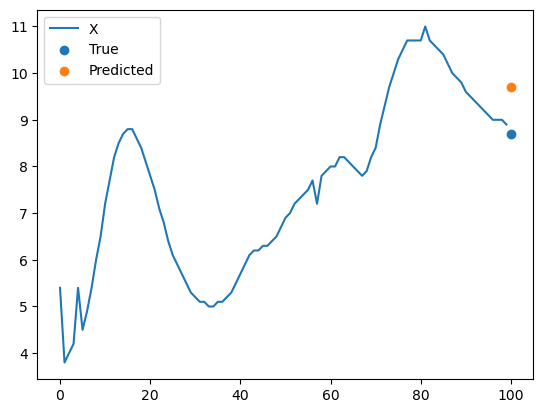

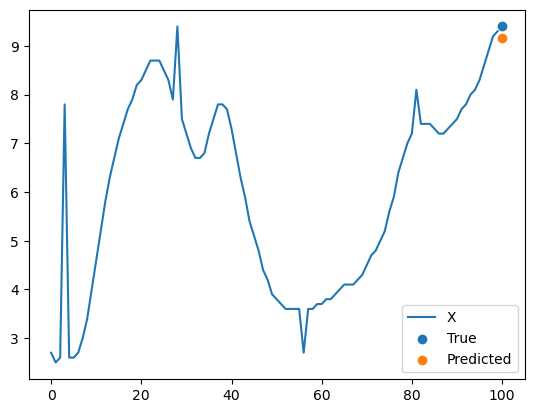

Patient 1:
  True y: [8.699999809265137]
  Predicted y: [9.697541236877441]

Patient 2:
  True y: [9.399999618530273]
  Predicted y: [9.15976333618164]



In [65]:
# Switch to evaluation mode
model.eval()

# Store all true and predicted values
all_true_y = []
all_pred_y = []

# Iterate over the entire test dataset
with torch.no_grad():  # Disable gradient calculation
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(-1)  # Ensure shape: (batch_size, 100, 1)

        # Get predictions
        y_pred = model(X_batch)
        plt.plot(X_batch.detach().numpy()[0, :, 0], label='X')
        plt.scatter(100, y_batch.detach().numpy(), label='True')
        plt.scatter(100, y_pred.detach().numpy(), label='Predicted')
        plt.legend()
        plt.show()
        # Store results
        all_true_y.extend(y_batch.tolist())
        all_pred_y.extend(y_pred.tolist())

# Print results
for i, (true_vals, pred_vals) in enumerate(zip(all_true_y, all_pred_y)):
    print(f"Patient {i+1}:")
    print(f"  True y: {true_vals}")
    print(f"  Predicted y: {pred_vals}\n")


In [ ]:
for y, y_pred, X in zip(y_sample, y_pred_sample, X_sample):
    plt.plot(X.detach().numpy(), label='X')
    plt.scatter(100, y.detach().numpy(), label='True')
    plt.scatter(100, y_pred.detach().numpy(), label='Predicted')
    plt.legend()
    plt.show()

NameError: name 'y_sample' is not defined

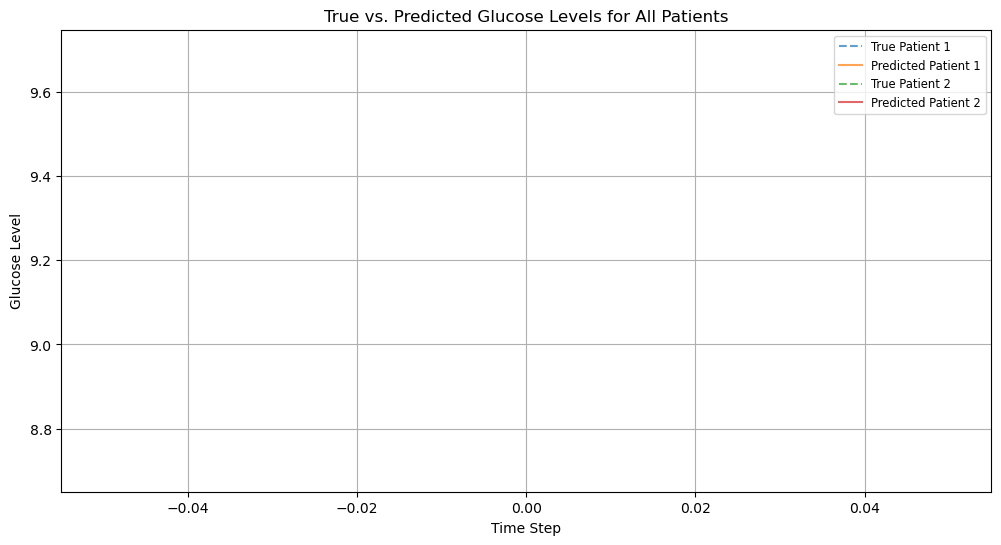

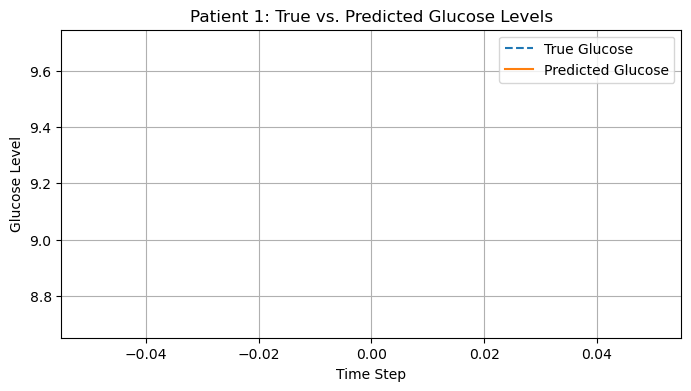

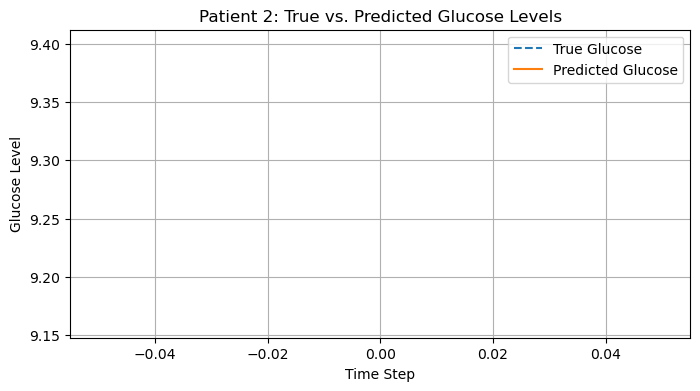

In [54]:
import matplotlib.pyplot as plt
import torch

# Ensure the model is in evaluation mode
model.eval()

# Store all true and predicted values
all_true_y = []
all_pred_y = []

# Iterate over the test dataset
with torch.no_grad():  # Disable gradient computation
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.unsqueeze(-1)  # Ensure shape: (batch_size, sequence_length, 1)

        # Get model predictions
        y_pred = model(X_batch)

        # Store results
        all_true_y.extend(y_batch.cpu().tolist())
        all_pred_y.extend(y_pred.cpu().tolist())

# Convert lists to tensors for plotting
all_true_y = torch.tensor(all_true_y)
all_pred_y = torch.tensor(all_pred_y)

# Plot all test patients
plt.figure(figsize=(12, 6))
for i in range(len(all_true_y)):  # Iterate over test cases
    plt.plot(all_true_y[i], label=f"True Patient {i+1}", linestyle="dashed", alpha=0.7)
    plt.plot(all_pred_y[i], label=f"Predicted Patient {i+1}", alpha=0.7)

plt.xlabel("Time Step")
plt.ylabel("Glucose Level")
plt.title("True vs. Predicted Glucose Levels for All Patients")
plt.legend(loc="best", fontsize="small")
plt.grid(True)
plt.show()

# Plot individual patient results separately
for i, (true_vals, pred_vals) in enumerate(zip(all_true_y, all_pred_y)):
    plt.figure(figsize=(8, 4))
    plt.plot(true_vals, label="True Glucose", linestyle="dashed")
    plt.plot(pred_vals, label="Predicted Glucose")
    plt.xlabel("Time Step")
    plt.ylabel("Glucose Level")
    plt.title(f"Patient {i+1}: True vs. Predicted Glucose Levels")
    plt.legend()
    plt.grid(True)
    plt.show()
